# Wasserstein GAN with Gradient Penalty (WGAN-GP)

* WGAN https://arxiv.org/pdf/1701.07875.pdf
* WGAN-GP https://arxiv.org/pdf/1704.00028.pdf

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

from utils.plot import show_tensor_images, show_loss_graph

## Generator

In [2]:
class Generator(nn.Module):
    
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim

        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=(kernel_size, kernel_size), stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=(kernel_size, kernel_size), stride=stride),
                nn.Tanh(),
            )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)


def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

## Critic

Discriminator is essentialy just a classifier and return values between 0 and 1 wich introduces the vanishing gradient / mode collapse problem. On the other hand, critic return value between -inf. and inf. and that allows generator to learn.

In [3]:
class Critic(nn.Module):

    def __init__(self, im_chan=1, hidden_dim=16):
        super(Critic, self).__init__()

        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=(kernel_size, kernel_size), stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=(kernel_size, kernel_size), stride=stride),
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Config

In [4]:
n_epochs = 50

# Set parameters
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002

beta_1 = 0.5
beta_2 = 0.999 # default
c_lambda = 10
crit_repeats = 5
device = 'cuda'

# Tranform the image values to be between -1 and 1 (the range of the tanh activation)
# MNIST data is on the interval [0, 1]-> subtract 0.5 -> [-0.5, 0.5] -> devide by 0.5 -> [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('./datasets', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [5]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

# Initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

## Training

In [ ]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    '''

    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    return ((gradient_norm - torch.ones_like(gradient_norm)) ** 2).mean()

In [ ]:
generator_loss_path = []
critic_loss_path = []
fake_path = []

tqdm_epochs = tqdm(range(n_epochs), unit="epoch")
for epoch in tqdm_epochs:
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.to(device)

        iteration_critic_loss = 0
        for _ in range(crit_repeats):
            # Update critic
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = (crit_fake_pred - crit_real_pred + gp * c_lambda).mean()

            crit_loss.backward(retain_graph=True)
            crit_opt.step()

            # Keep track of the average critic loss
            iteration_critic_loss += crit_loss.item() / crit_repeats
        

        # Update generator
        gen_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        crit_fake_pred = crit(fake)
        gen_loss = -crit_fake_pred.mean()

        gen_loss.backward(retain_graph=True)
        gen_opt.step()

        # Keep track of the average losses
        critic_loss_path.append(iteration_critic_loss)
        generator_loss_path.append(gen_loss.item())


    # Keep track of generator fakes
    tqdm_epochs.set_postfix({"Generator loss": generator_loss_path[-1], "Critic loss": critic_loss_path[-1]})
    with torch.no_grad():
        fake_noise = get_noise(25, z_dim, device=device)
        fake_path.append(gen(fake_noise))

## Checkpoints

In [6]:
checkpoint_path = "./checkpoints/W_GAN.pt"

# Save
# torch.save({
#     "epoch": n_epochs,

#     "gen": gen.state_dict(),
#     "gen_opt": gen_opt.state_dict(),
#     "gen_loss_path": generator_loss_path,

#     "crit": crit.state_dict(),
#     "crit_opt": crit_opt.state_dict(),
#     "crit_loss_path": critic_loss_path,

#     "fake_path": fake_path
# }, checkpoint_path)

# Load
checkpoint = torch.load(checkpoint_path)
gen.load_state_dict(checkpoint["gen"])
crit.load_state_dict(checkpoint["crit"])
gen.eval()
crit.eval()

generator_loss_path = checkpoint["gen_loss_path"]
critic_loss_path = checkpoint["crit_loss_path"]
fake_path = checkpoint["fake_path"]

## Visualize Learning Path

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


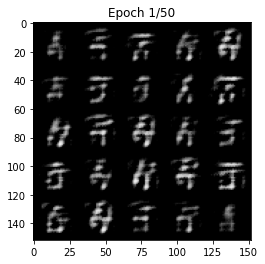

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


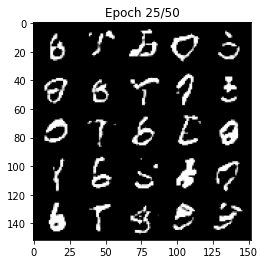

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


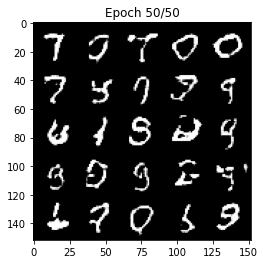

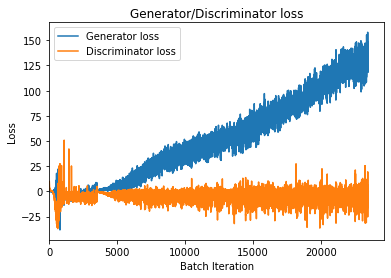

In [7]:
show_tensor_images(fake_path[0],    title=f"Epoch 1/{n_epochs}",            save_path="./figures/W_GAN_Epoch_01.pdf")
show_tensor_images(fake_path[24],   title=f"Epoch 25/{n_epochs}",           save_path="./figures/W_GAN_Epoch_25.pdf")
show_tensor_images(fake_path[-1],   title=f"Epoch {n_epochs}/{n_epochs}",   save_path="./figures/W_GAN_Epoch_50.pdf")

show_loss_graph(generator_loss_path, critic_loss_path, title="Generator/Discriminator loss", save_path="./figures/W_GAN_Loss.pdf")

## Conclusion

TODO - Why generator loss is keep increasing


## Cleanup

In [8]:
%reset